# Importing libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns # Visualization package
import matplotlib.pyplot as plt
from math import log
from scipy.stats import mannwhitneyu


Mounted at /content/drive


# Importing datasets

In [ ]:
df_neg = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/datasets/Metabolomics_Negative.xlsx")

#Transpose
df_neg = df_neg.T

df_neg.columns = df_neg.iloc[1]  # Use name row as header
df_neg = df_neg.drop(index="Name")

# Utility extractions
metadata_columns = ['MEDIA QC', 'DEV.ST QC', 'CV% QC']
mz_values_neg = df_neg.iloc[0].values

df_neg = df_neg.drop(index=["MEDIA QC","DEV.ST QC", "CV% QC"])
df_neg



In [ ]:
df_pos = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/datasets/Metabolomics_Positive.xlsx")

df_pos = df_pos.T

df_pos.columns = df_pos.iloc[1]  # Use name row as header
df_pos = df_pos.drop(index="Name")

mz_values_pos = df_pos.iloc[0].values

df_pos

#Deleting QC samples and duplicates

In [ ]:
#Deleting QC samples and duplicates
df_neg_no_qc = df_neg[~df_neg.index.str.startswith('QC')]
df_neg_no_qc['index_head'] = df_neg_no_qc.index.str[:9]
df_neg_no_duplicate = df_neg_no_qc[~df_neg_no_qc['index_head'].duplicated(keep='first')]
df_neg_no_duplicate = df_neg_no_duplicate.drop(columns=['index_head'])
df_neg_no_duplicate

In [ ]:
#Deleting QC samples and duplicates
df_pos_no_qc = df_pos[~df_pos.index.str.startswith('QC')]
df_pos_no_qc['index_head'] = df_pos_no_qc.index.str[:9]
df_pos_no_duplicate = df_pos_no_qc[~df_pos_no_qc['index_head'].duplicated(keep='first')]
df_pos_no_duplicate = df_pos_no_duplicate.drop(columns=['index_head'])
df_pos_no_duplicate

#PQN normalization

In [10]:
def PQN_normalization(df: pd.DataFrame,reference_sample = None)-> pd.DataFrame:
    df_norm = df.copy()
    if reference_sample is None:
      reference_sample=df_norm.iloc[1:].median(axis=0)

    for i in range(1, df_norm.shape[0]):

        df_norm.iloc[i]=df_norm.iloc[i]/((df_norm.iloc[i]/reference_sample).median())

    return df_norm,reference_sample


df_neg_pqn,_ = PQN_normalization(df_neg_no_duplicate)
df_pos_pqn,_ = PQN_normalization(df_pos_no_duplicate)

#Missing values substitution

In [11]:
def missing_values_substitution(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()
  for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    col_min = df[col].min(skipna=True)
    df[col] = df[col].fillna(col_min / 5)

  return df

if 'm/z meas.' in df_neg_pqn.index:
  df_neg_pqn.drop('m/z meas.', inplace=True)
df_neg_copy = missing_values_substitution(df_neg_pqn)

if 'm/z meas.' in df_pos_pqn.index:
  df_pos_pqn.drop('m/z meas.', inplace=True)
df_pos_copy = missing_values_substitution(df_pos_pqn)


#Log transform and autoscaling

In [12]:
def log_transform(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()
  for i in range(0, df.shape[0]):
    for j in range(0, df.shape[1]):
      df.iloc[i,j] = log(df.iloc[i,j], 10)
  return df

neg_log_transform = log_transform(df_neg_copy)
pos_log_transform = log_transform(df_pos_copy)

In [13]:
def autoscaling(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()
  mean = df.mean(axis=0)
  std = df.std(axis=0)
  for n, (i, j) in enumerate(zip(mean.values, std.values)):
    df.iloc[:, n] = (df.iloc[:, n] - i) / j
  return df

neg_autoscaling = autoscaling(neg_log_transform)
pos_autoscaling = autoscaling(pos_log_transform)

#Box plots

In [18]:
# List of the features selected by the ML models
feature_selected = ['Adenosine Monophosphate', 'Palmitoleoyl ethanolamide', 'Oleamide',
       'Epoxyoctadecenoic acid', 'Hydroxypregnenolone sulfate', 'Gluconate',
       'Hydroxydodecanoic acid', 'Glyceraldehyde', 'Uridine',
       'Glycoursodeoxycholic acid', 'Methylmaleate']

f_neg = ['Adenosine Monophosphate','Hydroxypregnenolone sulfate','Gluconate', 'Glyceraldehyde', 'Uridine', 'Glycoursodeoxycholic acid', 'Methylmaleate']

f_pos = ['Palmitoleoyl ethanolamide', 'Oleamide','Epoxyoctadecenoic acid', 'Hydroxydodecanoic acid']

In [19]:
import matplotlib.pyplot as plt

def group_features_by_group(df, features):

    available_features = [feature for feature in features if feature in df.columns]


    chd_rows = df[df.index.str.startswith('CHD')]
    ctrl_rows = df[df.index.str.startswith('CTRL')]

    # Select only columns of the available features
    chd_group = chd_rows[available_features]
    ctrl_group = ctrl_rows[available_features]

    return chd_group, ctrl_group


# Group data
chd_df1, ctrl_df1 = group_features_by_group(neg_autoscaling, feature_selected)
chd_df2, ctrl_df2 = group_features_by_group(pos_autoscaling, feature_selected)

In [ ]:
# View data
print("CHD group in neg DataFrame:")
print(chd_df1)
print("\nCTRL group in neg DataFrame:")
print(ctrl_df1)

print("\nCHD group in pos DataFrame:")
print(chd_df2)
print("\nCTRL group in pos DataFrame:")
print(ctrl_df2)

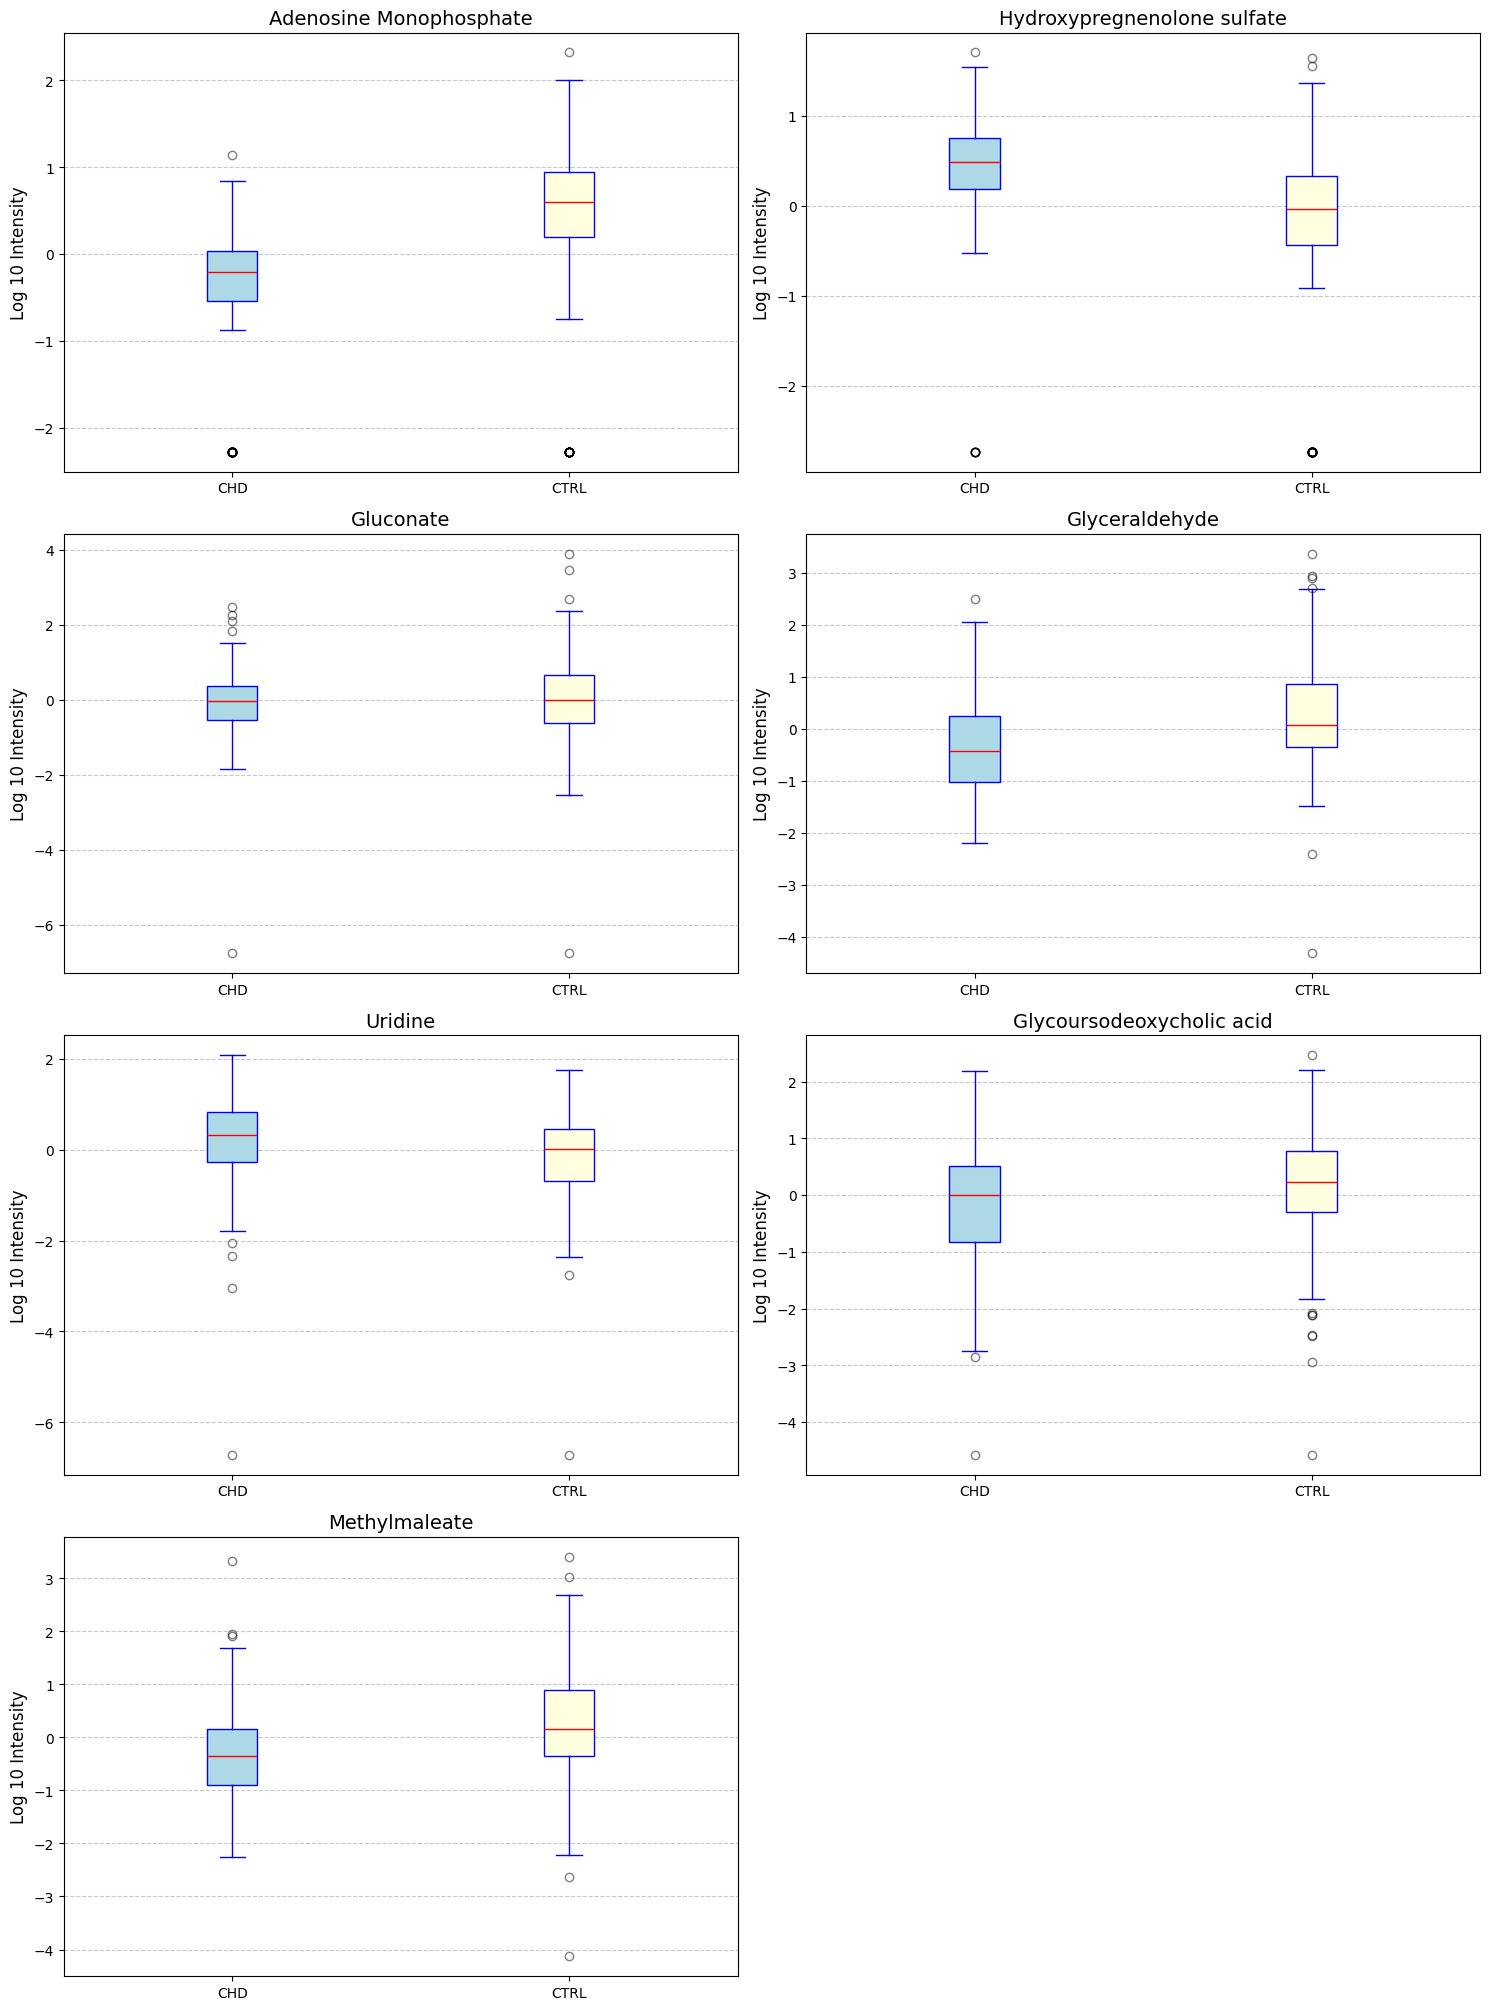

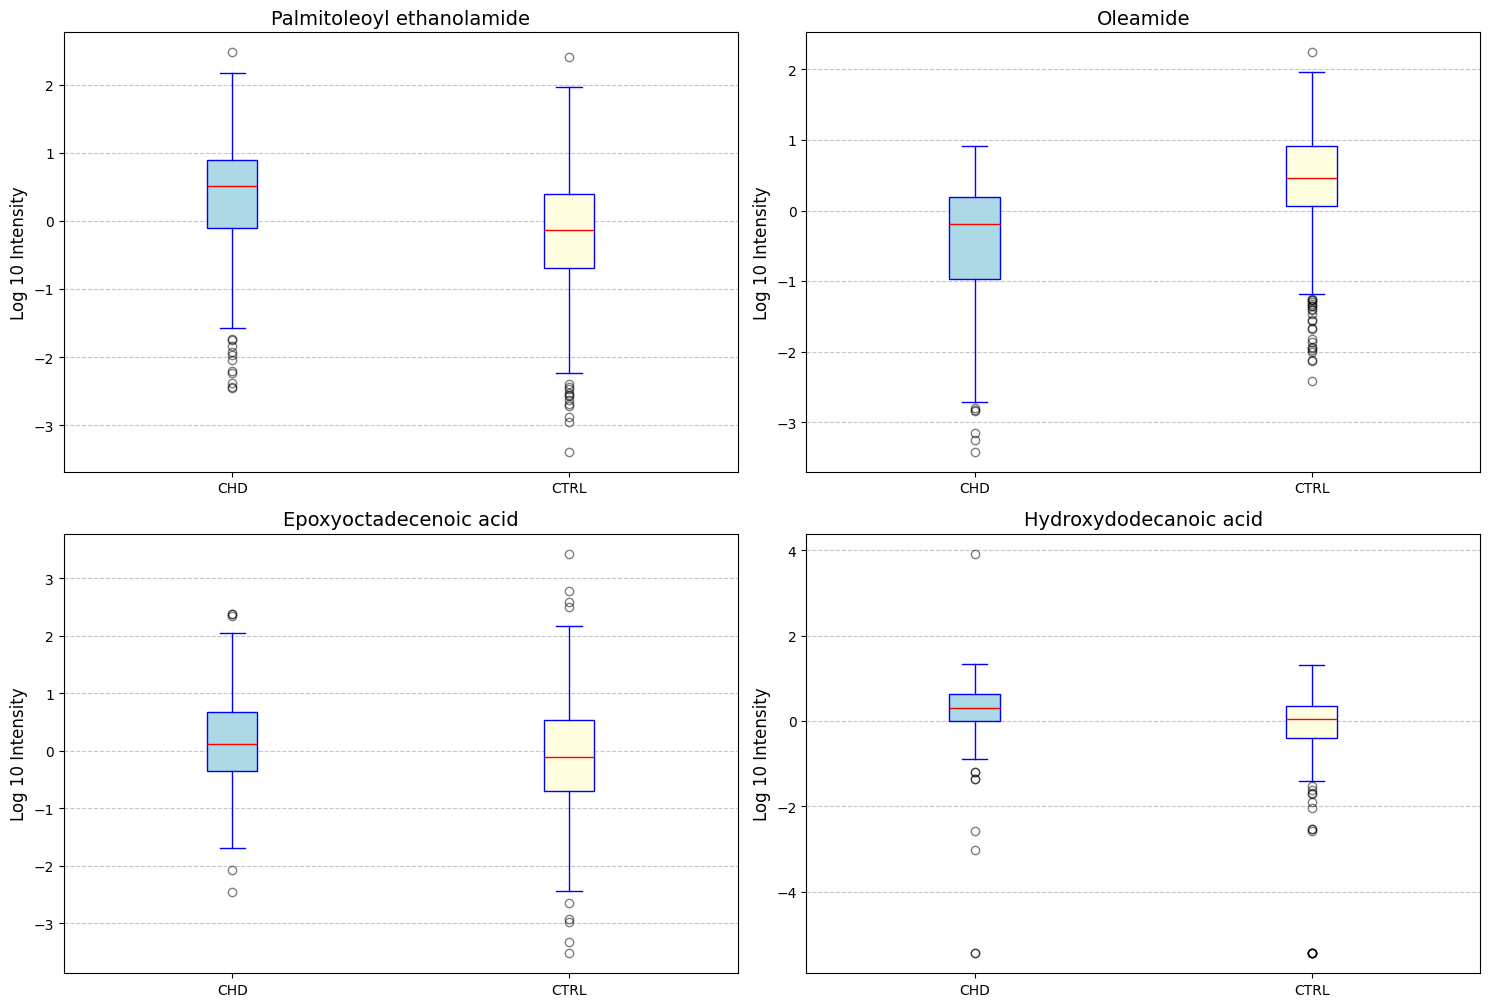

In [21]:
def plot_boxplots(chd_df, ctrl_df, features):
    num_features = len(features)
    num_rows = 6
    num_cols = 2
    plt.figure(figsize=(15, 5 * num_rows))

    for i, feature in enumerate(features):
      row = i // num_cols
      col = i % num_cols
      plt.subplot(num_rows, num_cols, i + 1)
      bp = plt.boxplot(
                [chd_df[feature], ctrl_df[feature]],
                tick_labels=['CHD', 'CTRL'],
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'),
                flierprops=dict(marker='o', color='blue', alpha=0.5)
            )
      bp['boxes'][1].set(facecolor='lightyellow')
      plt.title(f'{feature}', fontsize=14)
      plt.ylabel('Log 10 Intensity', fontsize=12)
      plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


plot_boxplots(chd_df1, ctrl_df1, f_neg)
plot_boxplots(chd_df2, ctrl_df2, f_pos)


#Mann-Whitney U test

In [22]:
# Group data
chd_df1, ctrl_df1 = group_features_by_group(df_neg_copy, feature_selected)
chd_df2, ctrl_df2 = group_features_by_group(df_pos_copy, feature_selected)


In [23]:
alpha = 0.001

def mann_whitney_test(chd_df, ctrl_df, feature):
  for metabolite in feature:
    res = mannwhitneyu(chd_df[metabolite], ctrl_df[metabolite], method='asymptotic')
    print(f'Mann-Whitney results for {metabolite}: {res}\n')
    p_value = res.pvalue
    if p_value <= alpha:
        print(f"{metabolite}: CHD and CTRL groups are significantly different.\n")
    else:
        print(f"{metabolite}: CHD and CTRL groups are not significantly different.\n")


mann_whitney_test(chd_df1, ctrl_df1, f_neg)
mann_whitney_test(chd_df2, ctrl_df2, f_pos)


Mann-Whitney results for Adenosine Monophosphate: MannwhitneyuResult(statistic=7758.0, pvalue=3.2081831647619994e-34)

Adenosine Monophosphate: CHD and CTRL groups are significantly different.

Mann-Whitney results for Hydroxypregnenolone sulfate: MannwhitneyuResult(statistic=37039.5, pvalue=8.563642317139269e-23)

Hydroxypregnenolone sulfate: CHD and CTRL groups are significantly different.

Mann-Whitney results for Gluconate: MannwhitneyuResult(statistic=23341.0, pvalue=0.6363488856995222)

Gluconate: CHD and CTRL groups are not significantly different.

Mann-Whitney results for Glyceraldehyde: MannwhitneyuResult(statistic=15350.5, pvalue=9.224618663056754e-11)

Glyceraldehyde: CHD and CTRL groups are significantly different.

Mann-Whitney results for Uridine: MannwhitneyuResult(statistic=29873.5, pvalue=9.128931927425866e-06)

Uridine: CHD and CTRL groups are significantly different.

Mann-Whitney results for Glycoursodeoxycholic acid: MannwhitneyuResult(statistic=18979.5, pvalue=0.